In [2]:
import gdal
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [4]:
def getBands(filename):
    img = gdal.Open(filename)
    bands = []
    for i in range(img.RasterCount):
        band = img.GetRasterBand(i+1).ReadAsArray().astype(np.float)
        bands.append(band)
    bands = np.dstack((bands[0],bands[1],bands[2],bands[3]))
    return bands
def maxminNorm(data):
    '''
    01标准化
    '''
    data=data.astype(np.float32)
    dmax=data.max()
    dmin=data.min()
    return (data-data.min())/(dmax-dmin)

def rgbNorm(data):
    '''
    01标准化
    '''
    data=data.astype(np.float32)
    dmax=data.max()
    dmin=data.min()
    dst=(data-data.min())/(dmax-dmin)*255
    dst=dst+0.5
    return dst.astype(np.uint8)


def index(data,ind="NDVI"):
    '''
    input:原始数据，默认保持影像形状，默认计算NDVI
    returns:相应指数
    '''
    nir=data[:,:,3]
    red=data[:,:,2]
    grn=data[:,:,1]
    blue=data[:,:,0]
    if ind=="NDVI":# 归一化植被指数 
        NDVI=(nir-red)/(nir+red+1e-8)
        return NDVI
    elif ind=="NDWI":# 归一化水体指数
        NDWI=(grn-nir)/(grn+nir+1e-8)
        return NDWI
    elif ind=="CIg":# 叶绿素指数-绿边 
        CIg=nir/(grn+1e-8)-1
        return CIg
    elif ind=="EVI":# 增强型植被指数 
        EVI=2.5*(nir-red)/(nir+ 6*red-7.5*blue+1+1e-8)
        return EVI
    elif ind=="GNDVI":# 绿光归一化差值植被指数
        GNDVI = (nir - grn)/(nir + grn+1e-8)
        return GNDVI
    elif ind=="MSAVI":# 修正土壤调节植被指数
        MSAVI=0.5*(2*(nir +1)-np.sqrt((2*nir+1)**2-8*(nir-red)))
        return MSAVI
    elif ind=="MTVI":# 修正型三角植被指数
        MTVI=1.5*(1.2*(nir-grn)-2.5*(red-grn))/np.sqrt((2*nir+1)**2-(6*nir-5*np.sqrt(red))-0.5)
        return MTVI
    elif ind=="SAVI":# 土壤调节植被指数
        L=0.5
        SAVI=((nir-red)/(nir+red+L))*(1+L)
        return SAVI
    elif ind=="VARI":# 可视化大气阻抗指数
        VARI=(grn-red)/(grn+red-blue+1e-8)
        return VARI
    
def returnLabeldata(data,indexName,df=False,reshape=True,norm=False):
    h,w,d=data.shape
    dataIdx=np.zeros((data.shape[0],data.shape[1],len(indexName)),dtype=np.float32)
    for i,idx in enumerate(indexName):
        if norm==True:
            dataIdx[:,:,i]=maxminNorm(index(data,ind=idx))
        else:
            dataIdx[:,:,i]=index(data,ind=idx)
    if len(np.unique(np.argwhere(np.isnan(dataIdx))[:,2]))!=0:
        print(np.unique(np.argwhere(np.isnan(dataIdx))[:,2]))
    if df==True:
        res=pd.DataFrame(dataIdx.reshape((h*w,-1)),columns=indexName)
    if reshape==True:
        res=dataIdx.reshape((h*w,-1))
    else:
        res=dataIdx
    return res

def addY(loc,data,nums):#data3维
    loc=loc.astype(np.int)
    y=np.zeros((sum(nums),1))
    s=0
    for i,num in enumerate(nums):
        y[s:s+num,0]=i
    x=np.zeros((sum(nums),data.shape[2]))
    for i,yx in enumerate(loc):
        x[i,:]=data[yx[1],yx[0],:]
    train=np.concatenate((x,y),axis=1)
    return train

In [5]:
path=r"E:\project\images\researchImage\HR\originData"
#img1=getBands(os.path.join(path,"000326.tif"))
img2=getBands(os.path.join(path,"040121.tif"))
img3=getBands(os.path.join(path,"090618.tif"))
#data1=img1[600:1000,600:1000,:]
data2=img2[600:1000,600:1000,:]
data3=img3[600:1000,600:1000,:]

In [6]:
indexName=["NDVI","NDWI","MSAVI","MTVI","VARI"]

In [6]:
labdata1=returnLabeldata(data1)
labdata2=returnLabeldata(data2)


In [7]:
pre1=cv2.imread(r"E:\project\images\researchImage\HR\label\pre00.tif",0).astype(np.uint8)
pre2=cv2.imread(r"E:\project\images\researchImage\HR\label\pre04.tif",0).astype(np.uint8)

In [8]:
rgb1=cv2.imread(r"E:\project\images\researchImage\HR\cut\rgb00.tif")
rgb2=cv2.imread(r"E:\project\images\researchImage\HR\cut\rgb04.tif")

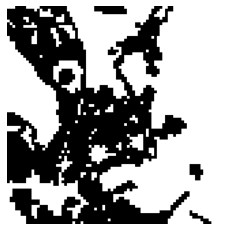

In [10]:
matchLst,mask=generator(pre1,pre2)

In [36]:
rgb1mask=getmask(rgb1,mask)
rgb2mask=getmask(rgb2,mask)
cv2.imwrite(r"E:\project\images\researchImage\HR\cut\rgb00mask.tif",rgb1mask)
cv2.imwrite(r"E:\project\images\researchImage\HR\cut\rgb04mask.tif",rgb2mask)

True

In [12]:
data1norm=maxminNorm(data1)
data2norm=maxminNorm(data2)
labdata1norm=maxminNorm(labdata1)
labdata2norm=maxminNorm(labdata2)
data1total=np.concatenate((data1norm,labdata1norm),axis=2)
data2total=np.concatenate((data2norm,labdata2norm),axis=2)

In [45]:
diff=np.sqrt(np.sum((data1total-data2total)**2,axis=2))
size=5
for i in range(int(diff.shape[0]/size)):
    for j in range(int(diff.shape[1]/size)):
        diff[i*size:(i+1)*size,j*size:(j+1)*size]=np.mean(diff[i*size:(i+1)*size,j*size:(j+1)*size])
diff=diff*mask
unmask=mask.copy()
unmask[diff>0.5]=0

(-0.5, 399.5, 399.5, -0.5)

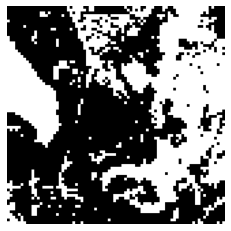

In [48]:
plt.imshow(unmask,'gray')
plt.axis('off')

In [60]:
rgb1unmask=getmask(rgb1,unmask,True)
rgb2unmask=getmask(rgb2,unmask,True)
cv2.imwrite(r"E:\project\images\researchImage\HR\cut\rgb00unmask.tif",rgb1unmask)
cv2.imwrite(r"E:\project\images\researchImage\HR\cut\rgb04unmask.tif",rgb2unmask)

True

In [57]:
cv2.imwrite(r"E:\project\images\researchImage\HR\label\unmask.tif",unmask)

True